# Imports & Environment Setup

In [23]:
# -*- coding: utf-8 -*-
"""
Portfolio Optimization Report
-----------------------------
This notebook downloads 10 years of weekly market data for various ETFs using yfinance.
It calculates returns, performs optimization, runs factor regressions (CAPM & Multi-Factor),
and generates clean PDF reports with matplotlib and plotly.

Outputs:
- Data CSV
- Portfolio charts
- Summary PDF report
"""

# === 1. STANDARD LIBRARIES ===
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime, timedelta
import io
from io import StringIO
from contextlib import redirect_stdout

# === 2. LIBRARY CHECK & INSTALLATION ===
required_libraries = [
    "yfinance", "pandas", "pandas_datareader", "matplotlib", "numpy", "seaborn",
    "arch", "plotly", "statsmodels", "nbformat", "nbconvert", "ipykernel", 
    "ipywidgets", "scipy", "kaleido"
]

missing_libraries = []
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        missing_libraries.append(lib)

if missing_libraries:
    print(f"Installing missing libraries: {', '.join(missing_libraries)}...")
    for lib in missing_libraries:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
else:
    print("All required libraries are installed.")

# === 3. CORE PYTHON LIBRARIES ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import statsmodels.api as sm

# === 4. FINANCE / ECONOMIC LIBRARIES ===
import yfinance as yf
import pandas_datareader.data as web
from arch import arch_model

# === 5. INTERACTIVE & STATIC PLOTTING ===
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
from matplotlib.backends.backend_pdf import PdfPages

# === 6. MATPLOTLIB STYLE SETTINGS ===
plt.style.use("tableau-colorblind10")  # You may change to "bmh", "ggplot", etc.
plt.rcParams.update({
    "font.size": 10,
    "font.family": "sans-serif",
    "axes.titleweight": "bold",
    "axes.labelsize": 8,
    "axes.titlesize": 14,
    "grid.alpha": 0.3,
    "legend.frameon": False,
    "figure.dpi": 100
})

All required libraries are installed.


In [2]:
# Utility functions and initialization for figure collection and PDF report generation
def generate_pdf_report(figures, text_pages=None, filename="exports/portfolio_summary_report.pdf"):
    """
    Save a list of matplotlib figures and optional text pages to a single PDF report.
    
    Parameters:
    - figures (list): List of matplotlib Figure objects.
    - text_pages (list): Optional list of strings to render as pages of text.
    - filename (str): Output PDF file path.
    """
    pdf_path = Path(filename)
    pdf_path.parent.mkdir(parents=True, exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        # Save all figure pages
        for fig in figures:
            pdf.savefig(fig)
            plt.close(fig)

        # Save text pages if provided
        if text_pages:
            for text in text_pages:
                fig_text = plt.figure(figsize=(8.5, 11))
                plt.axis('off')
                plt.text(0, 1, text, fontsize=10, verticalalignment='top', fontfamily='arial', wrap=True)
                pdf.savefig(fig_text)
                plt.close(fig_text)

    return str(pdf_path)

def export_chart_with_table(chart_func, table_df, filename="exports/optimization_weights_summary.pdf"):
    fig = plt.figure(figsize=(8.5, 11))

    # Chart Area (top)
    ax_chart = fig.add_axes([0.1, 0.5, 0.85, 0.45])
    chart_func(ax_chart)

    # Table Area (bottom)
    ax_table = fig.add_axes([0.05, 0.05, 0.9, 0.35])
    ax_table.axis('off')

    table = ax_table.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1],
        colWidths=[0.4] + [0.2] * (table_df.shape[1])  # autosized-like
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 1.3)

    fig.suptitle("Optimal Portfolio Allocation", fontsize=16, y=0.98)

    pdf_path = Path(filename)
    pdf_path.parent.mkdir(parents=True, exist_ok=True)
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)
        plt.close(fig)

    print(f"PDF saved to: {pdf_path}")

figures = []

#  Portfolio File Parsing

In [3]:
# === Initialize output buffer for exportable stdout ===
stdout_buffer = io.StringIO()

# === Read and parse portfolio file ===
with open("port_details.txt", "r") as file:
    lines = file.readlines()

tickers = {}
constraints = {}
risk_free_rate = None
section = None

for line in lines:
    line = line.strip()
    if not line:
        continue
    elif line.endswith(":") and line.count(":") == 1:
        section = line[:-1]
    elif section == "Tickers":
        key, value = line.split(": ")
        tickers[key.strip()] = value.strip()
    elif section == "Risk-free Rate":
        risk_free_rate = float(line.strip())
    elif section == "Investment Constraints":
        if "<=" in line:
            key, value = line.split(" <= ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["max"] = value
        elif ">=" in line or ">" in line:
            key, value = line.split(" > ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["min"] = value

# === Define date range ===
end_date = datetime(2025, 6, 13)
start_date = end_date - timedelta(weeks=52 * 10)

# === Download weekly close prices ===
data = yf.download(
    tickers=list(tickers.values()),
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1wk",
    auto_adjust=False,
    back_adjust=False
)["Close"]

# === Rename columns to asset classes ===
ticker_to_asset = {v: k for k, v in tickers.items()}
data = data.rename(columns=ticker_to_asset)

priority = ['US_Stocks', 'US_Bonds', 'Dev_Stocks_ExUS', 'Dev_Bonds_ExUS',
            'EM_Stocks', 'EM_Bonds', 'Cash']
rest = [col for col in data.columns if col not in priority]
data = data[priority + rest]

# === Save data to CSV ===
os.makedirs("exports", exist_ok=True)
data.to_csv("exports/weekly_market_data_10yr_combined.csv")
print("Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.")

# === Display and capture output summary ===
with redirect_stdout(stdout_buffer):
    print("\nData Columns:")
    print(", ".join(data.columns))

    print("\nParsed Portfolio Details:")
    print("Tickers:", tickers)
    print("Risk-Free Rate:", risk_free_rate)
    print("Constraints:", constraints)

# Print to screen as well
print("\nData Columns:")
print(", ".join(data.columns))

print("\nParsed Portfolio Details:")
print("Tickers:", tickers)
print("Risk-Free Rate:", risk_free_rate)
print("Constraints:", constraints)

[*********************100%***********************]  8 of 8 completed

Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.

Data Columns:
US_Stocks, US_Bonds, Dev_Stocks_ExUS, Dev_Bonds_ExUS, EM_Stocks, EM_Bonds, Cash, Gold

Parsed Portfolio Details:
Tickers: {'US_Stocks': 'VOO', 'US_Bonds': 'AGG', 'Dev_Stocks_ExUS': 'SCHF', 'Dev_Bonds_ExUS': 'BNDX', 'EM_Stocks': 'VWO', 'EM_Bonds': 'EMB', 'Cash': 'BIL', 'Gold': 'GLD'}
Risk-Free Rate: 0.0441
Constraints: {'US_Stocks': {'max': 0.65, 'min': 0.1}, 'US_Bonds': {'max': 0.5, 'min': 0.2}, 'Dev_Stocks_ExUS': {'max': 0.4}, 'Dev_Bonds_ExUS': {'max': 0.4}, 'EM_Bonds': {'max': 0.15}, 'EM_Stocks': {'max': 0.15}, 'Cash': {'max': 0.1, 'min': 0.05}, 'Gold': {'max': 0.15}}


#  Data Download & Preparation

C:\Users\opelc\AppData\Local\Temp\ipykernel_51328\37454056.py:59: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



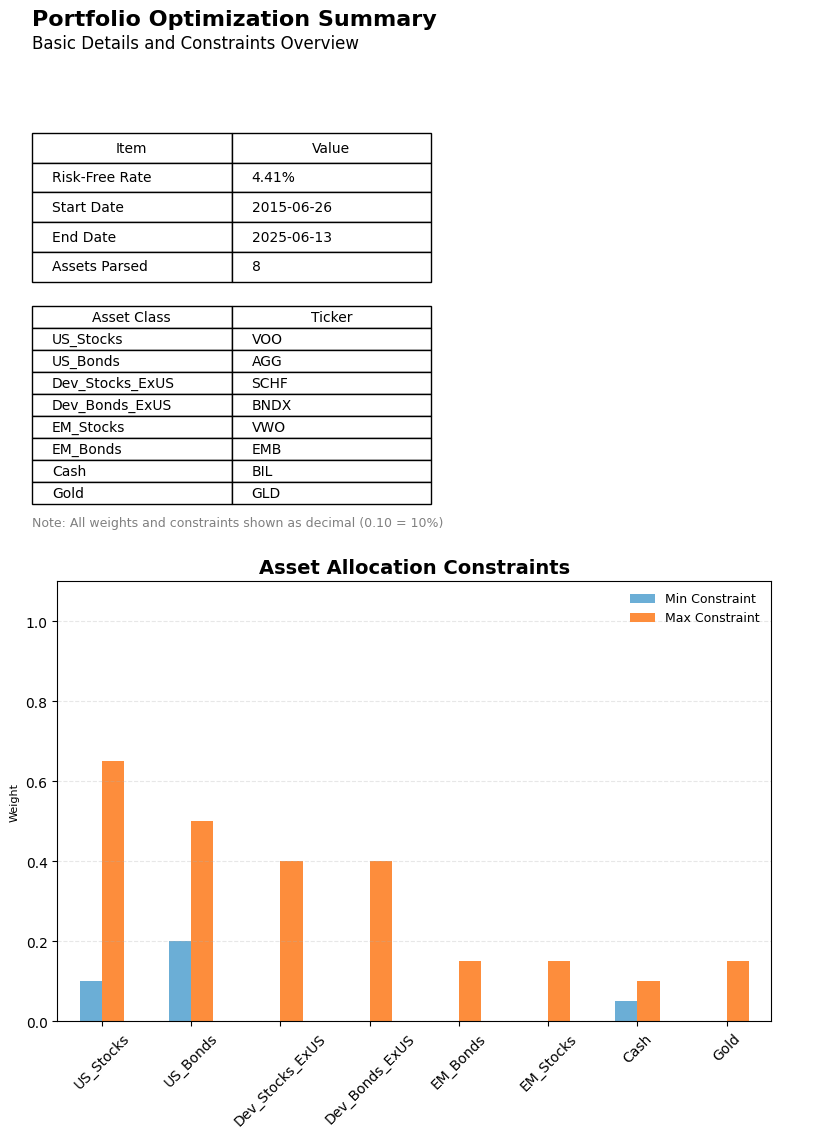

In [4]:
# === Metadata table ===
metadata_df = pd.DataFrame({
    "Item": ["Risk-Free Rate", "Start Date", "End Date", "Assets Parsed"],
    "Value": [f"{risk_free_rate:.2%}", start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), len(tickers)]
})

# === Asset class table ===
asset_df = pd.DataFrame(list(tickers.items()), columns=["Asset Class", "Ticker"])


# Convert to uniform DataFrame for plotting
constraint_df = pd.DataFrame(index=constraints.keys())
constraint_df['Min'] = [v.get('min', 0) for v in constraints.values()]
constraint_df['Max'] = [v.get('max', 1) for v in constraints.values()]

# === Create full-page figure ===
fig_combined = plt.figure(figsize=(8.5, 11))

# --- Section 1: Title and Summary Tables ---
ax_text = fig_combined.add_axes([0.05, 0.52, 0.94, 0.45])  # top half
ax_text.axis('off')

# Title
ax_text.text(0, 1.0, "Portfolio Optimization Summary", fontsize=16, weight='bold', va='top')
ax_text.text(0, 0.95, "Basic Details and Constraints Overview", fontsize=12, va='top')

# Metadata Table
table1 = ax_text.table(cellText=metadata_df.values,
                       colLabels=metadata_df.columns,
                       cellLoc='left',
                       loc='upper left',
                       bbox=[0, 0.45, 0.5, 0.3])
table1.auto_set_font_size(False)
table1.set_fontsize(10)

# Asset Table
table2 = ax_text.table(cellText=asset_df.values,
                       colLabels=asset_df.columns,
                       cellLoc='left',
                       loc='upper left',
                       bbox=[0, 0.0, 0.5, 0.4])
table2.auto_set_font_size(False)
table2.set_fontsize(10)

# --- Section 2: Constraints Chart ---
ax_bar = fig_combined.add_axes([0.08, 0.05, 0.84, 0.4])
constraint_df.plot(kind='bar', ax=ax_bar, color=["#6baed6", "#fd8d3c"])
ax_bar.set_title("Asset Allocation Constraints")
ax_bar.set_ylabel("Weight")
ax_bar.set_ylim(0, 1.1)
ax_bar.grid(axis='y', linestyle='--', alpha=0.3)
ax_bar.legend(["Min Constraint", "Max Constraint"], loc='upper right', fontsize=9)
ax_bar.tick_params(axis='x', rotation=45)

# === Add footer note ===
fig_combined.text(0.05, 0.5, "Note: All weights and constraints shown as decimal (0.10 = 10%)", fontsize=9, color="gray")

# === Export to figures ===
fig_combined.tight_layout()
figures.append(fig_combined)

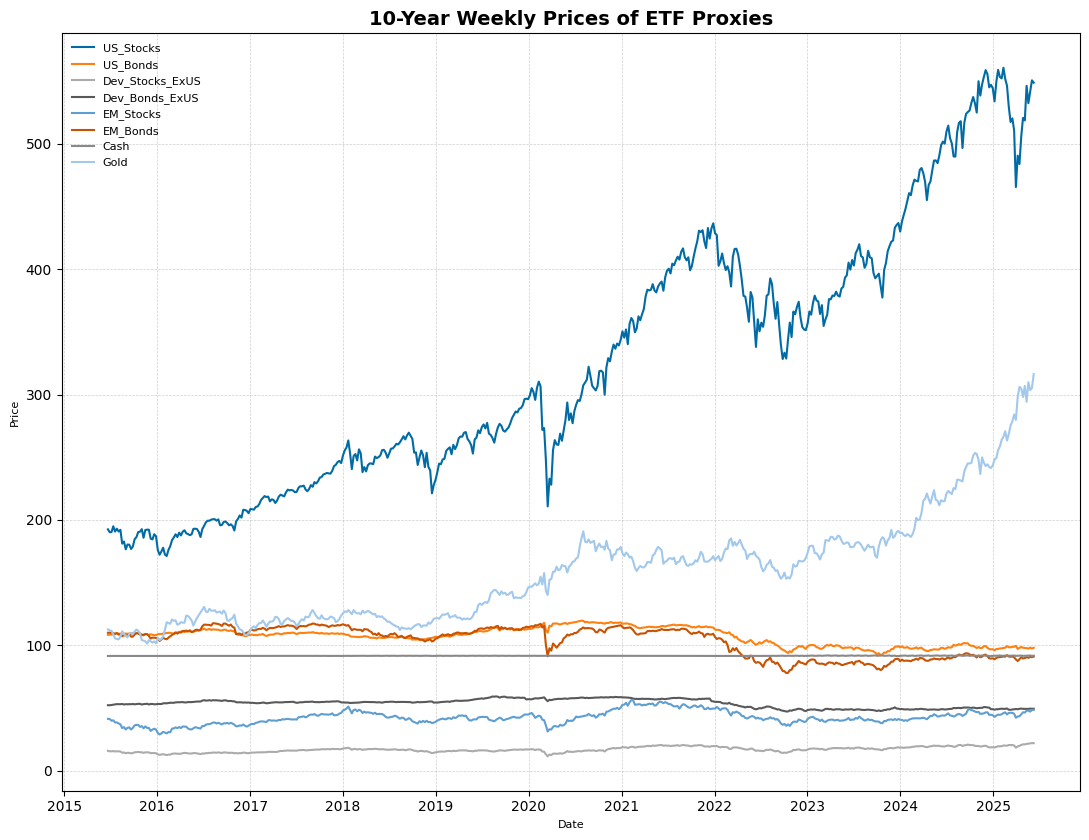

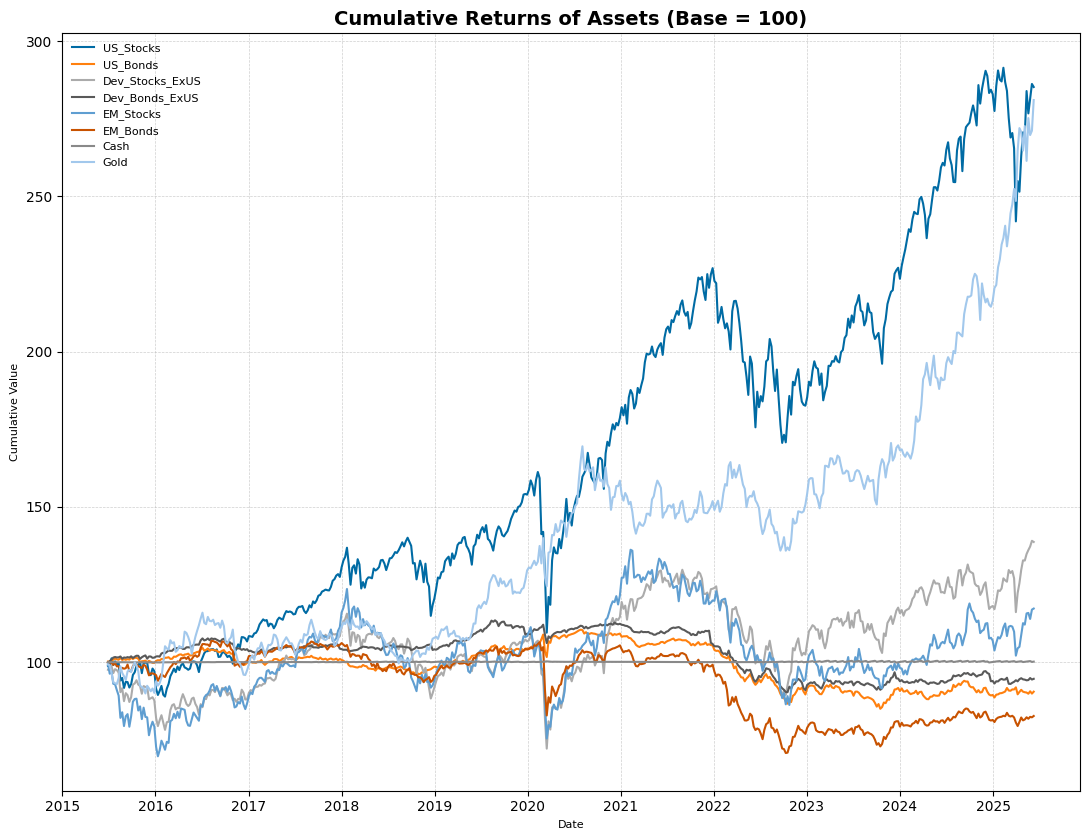

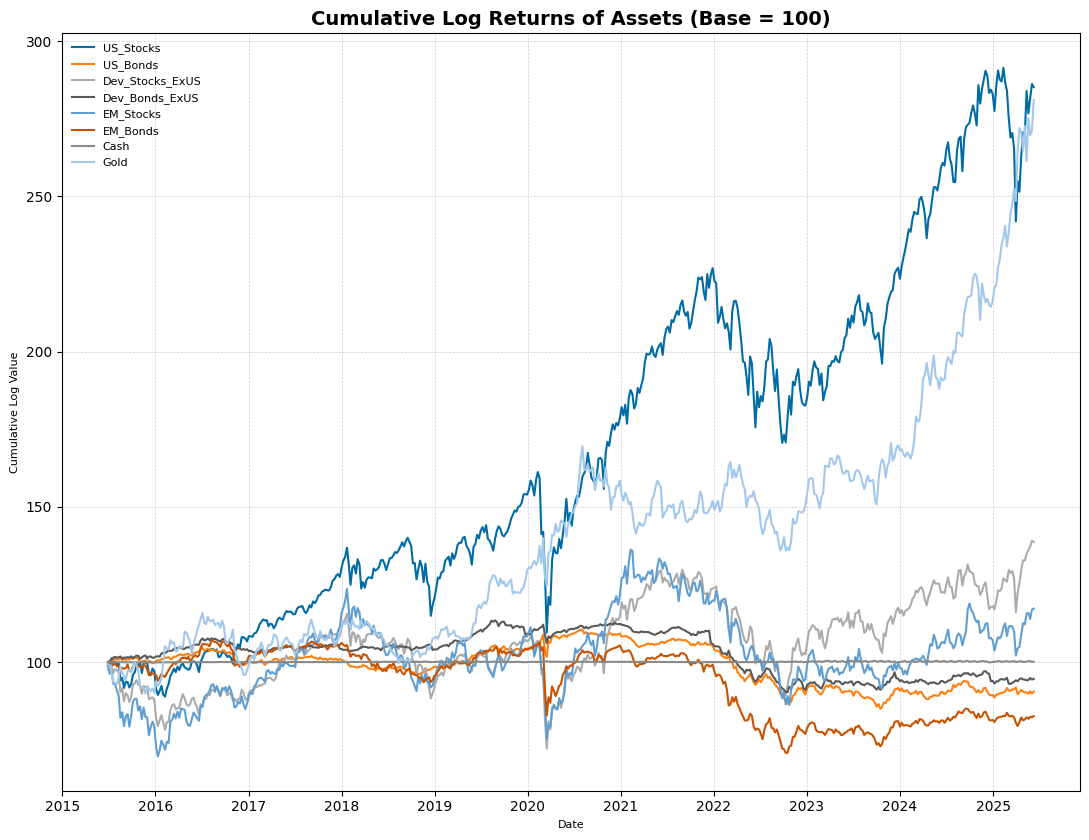

In [5]:
# === Setup: calculate required series ===
simple_returns = data.pct_change().dropna()
cumulative_returns = (1 + simple_returns).cumprod() * 100

log_returns = np.log(data / data.shift(1)).dropna()
cum_log_returns = np.exp(log_returns.cumsum()) * 100

# === 1. Weekly Prices Line Chart ===
fig_prices, ax1 = plt.subplots(figsize=(11, 8.5))
for col in data.columns:
    ax1.plot(data.index, data[col], label=col)

ax1.set_title('10-Year Weekly Prices of ETF Proxies', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax1.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_prices)

# === 2. Cumulative Returns Line Chart ===
fig_cum, ax2 = plt.subplots(figsize=(11, 8.5))
for col in cumulative_returns.columns:
    ax2.plot(cumulative_returns.index, cumulative_returns[col], label=col)

ax2.set_title('Cumulative Returns of Assets (Base = 100)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Value')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_cum)

# === 3. Cumulative Log Returns Line Chart ===
fig_log, ax3 = plt.subplots(figsize=(11, 8.5))
for col in cum_log_returns.columns:
    ax3.plot(cum_log_returns.index, cum_log_returns[col], label=col)

ax3.set_title('Cumulative Log Returns of Assets (Base = 100)', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Log Value')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax3.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_log)

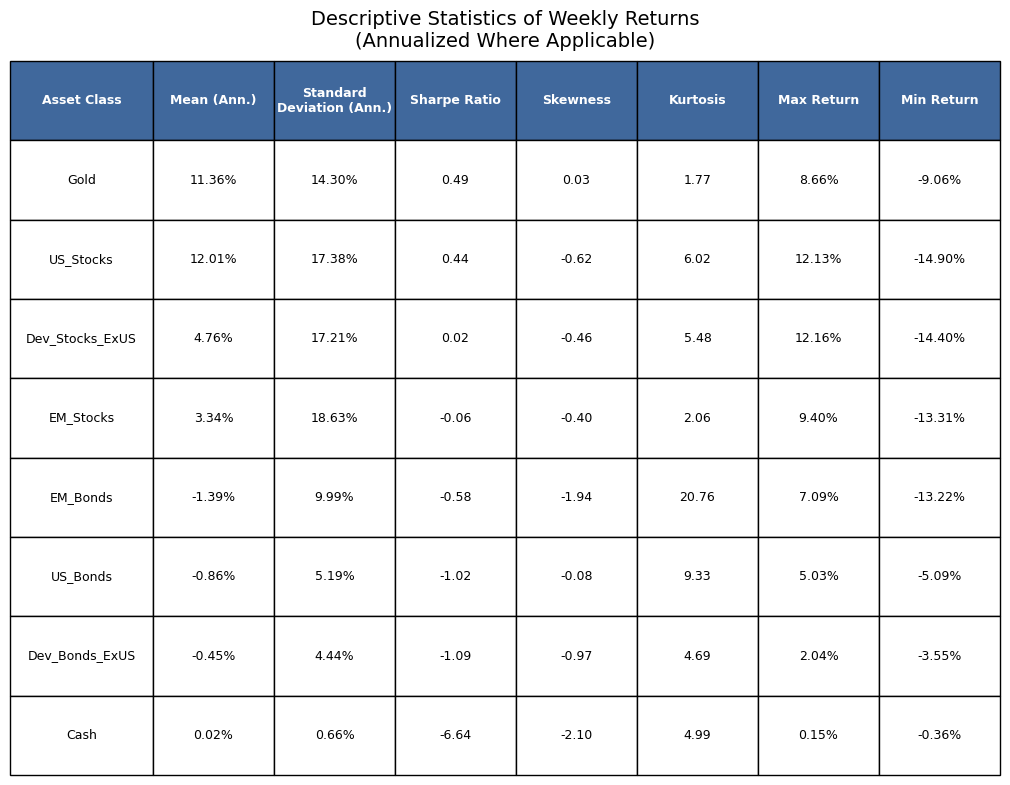

In [6]:
# Descriptive statistics for ETF weekly return series
assets =  data.columns
desc_stats = pd.DataFrame(index=assets)

# Mean (expected return, annualized)
desc_stats['Mean (Ann.)'] = simple_returns.mean() * 52

# Standard deviation (volatility, annualized)
desc_stats['Standard\nDeviation (Ann.)'] = simple_returns.std() * np.sqrt(52)

# Skewness (asymmetry)
desc_stats['Skewness'] = simple_returns.skew()

# Kurtosis (fat tails)
desc_stats['Kurtosis'] = simple_returns.kurtosis()

# Max/min weekly returns
desc_stats['Max Return'] = simple_returns.max()
desc_stats['Min Return'] = simple_returns.min()

# Sharpe Ratio (annualized)
desc_stats['Sharpe Ratio'] = (simple_returns.mean() * 52 - risk_free_rate) / (simple_returns.std() * np.sqrt(52))

desc_stats = desc_stats.reset_index()
desc_stats = desc_stats.rename(columns={'Ticker': 'Asset Class'})
# Reorder columns for better readability
desc_stats = desc_stats[['Asset Class', 'Mean (Ann.)', 'Standard\nDeviation (Ann.)',
                         'Sharpe Ratio', 'Skewness', 'Kurtosis',
                         'Max Return', 'Min Return']]
# Sort by Sharpe Ratio
desc_stats = desc_stats.sort_values(by='Sharpe Ratio', ascending=False)

# === Format Values ===
formatted_desc_stats = desc_stats.copy()

# Format percentages
cols_pct = ['Mean (Ann.)', 'Standard\nDeviation (Ann.)', 'Max Return', 'Min Return']
for col in cols_pct:
    formatted_desc_stats[col] = formatted_desc_stats[col].map(lambda x: f"{x:.2%}")

# Format numeric ratios
formatted_desc_stats['Sharpe Ratio'] = formatted_desc_stats['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
formatted_desc_stats['Skewness'] = formatted_desc_stats['Skewness'].apply(lambda x: f"{x:.2f}")
formatted_desc_stats['Kurtosis'] = formatted_desc_stats['Kurtosis'].apply(lambda x: f"{x:.2f}")

# === Create Table ===
fig_stats = plt.figure(figsize=(11, 8.5))
ax = fig_stats.add_axes([0.05, 0.08, 0.9, 0.84])
ax.axis('off')

table = ax.table(
    cellText=formatted_desc_stats.values,
    colLabels=formatted_desc_stats.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.13] + [0.11] * (formatted_desc_stats.shape[1] - 1),
    bbox=[0, 0, 1, 1]
)

header_props = {
    "facecolor": "#40689c",
    "edgecolor": "white",
    "text_props": {
        "weight": "bold",
        "color": "white",
        "fontsize": 10
    }
}

# Apply formatting to each header cell
for col_idx in range(len(formatted_desc_stats.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor(header_props["facecolor"])
    cell.get_text().set_fontweight(header_props["text_props"]["weight"])
    cell.get_text().set_color(header_props["text_props"]["color"])
    cell.get_text().set_fontsize(header_props["text_props"]["fontsize"])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.suptitle("Descriptive Statistics of Weekly Returns\n(Annualized Where Applicable)", fontsize=14, y=0.98)
figures.append(fig_stats)


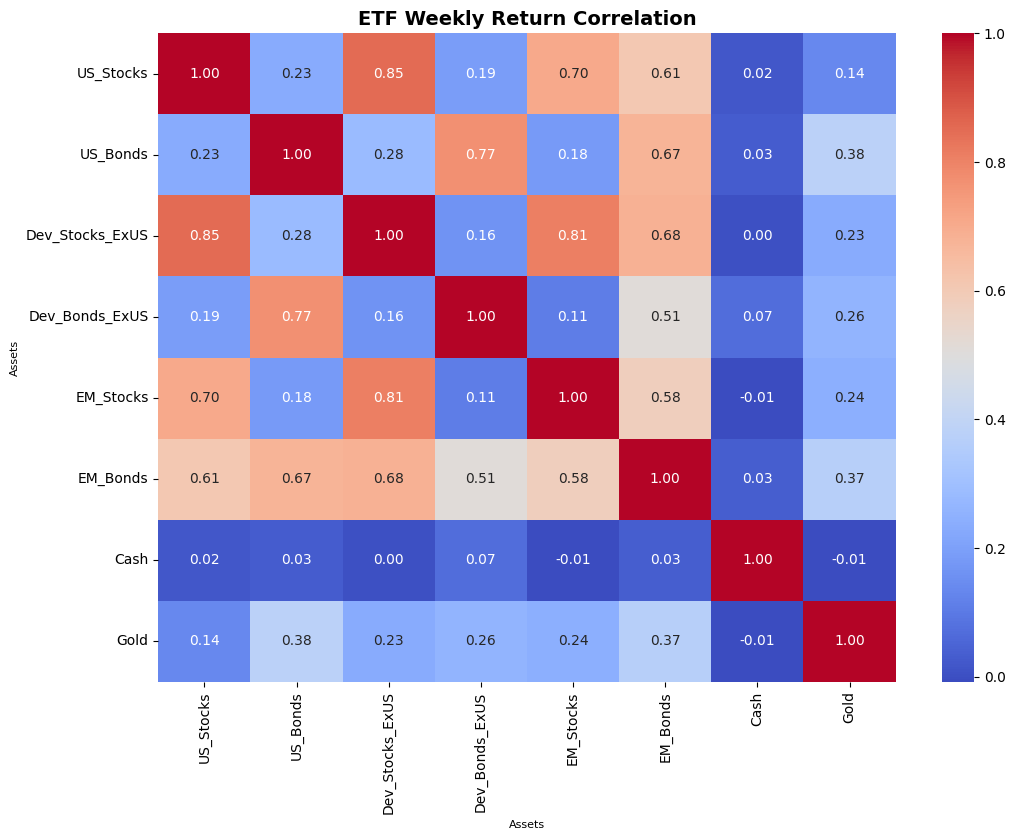

In [7]:
fig_corr = plt.figure(figsize=(11, 8.5))
sns.heatmap(simple_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ETF Weekly Return Correlation")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()
figures.append(fig_corr)

# 📈 Returns & Statistical Measures

# 🖼️ PDF Export Setup

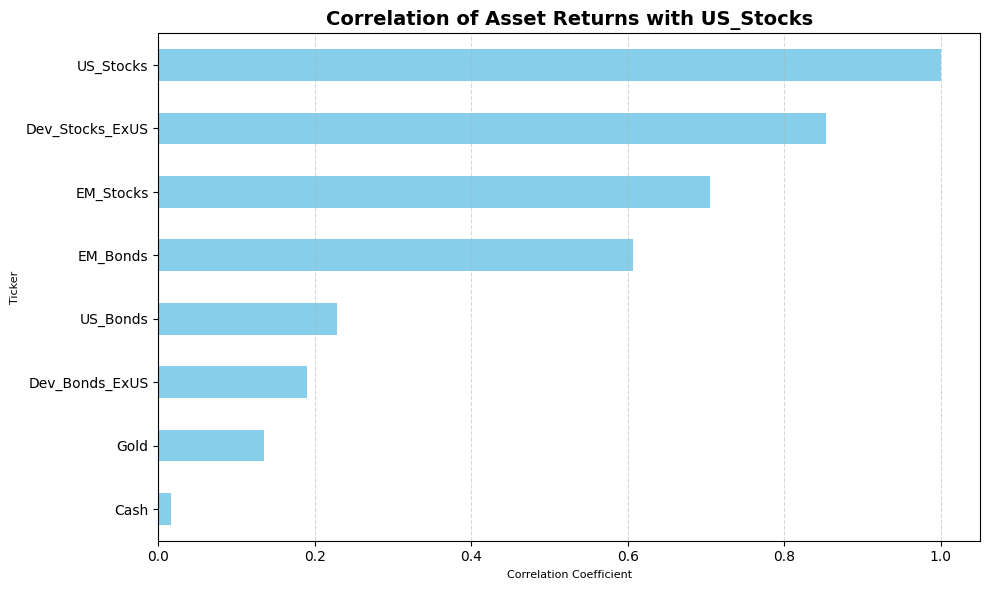

In [19]:
ref_asset = 'US_Stocks'
corr_vs_us = simple_returns.corr()[ref_asset].sort_values()

fig_corr_bar = plt.figure(figsize=(10, 6))
corr_vs_us.plot(kind='barh', color='skyblue')
plt.title(f"Correlation of Asset Returns with {ref_asset}")
plt.xlabel("Correlation Coefficient")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
figures.append(fig_corr_bar)

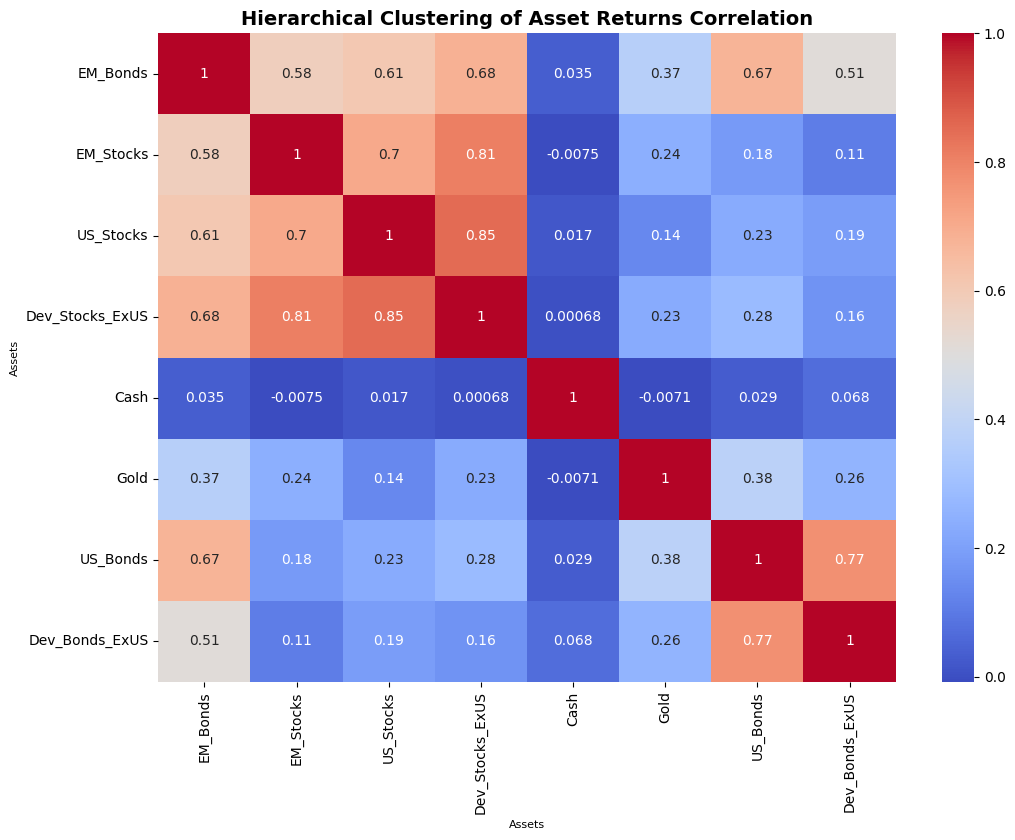

In [22]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Reorder based on clustering
corr_matrix = simple_returns.corr()
link = linkage(corr_matrix, method='ward')
order = leaves_list(link)
ordered_corr = corr_matrix.iloc[order, order]
fig_corr_clustered = plt.figure(figsize=(11, 8.5))
sns.heatmap(ordered_corr, cmap='coolwarm', annot=True)
plt.title("Hierarchical Clustering of Asset Returns Correlation")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.tight_layout()
figures.append(fig_corr_clustered)


C:\Users\opelc\AppData\Local\Temp\ipykernel_51328\3535948505.py:90: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



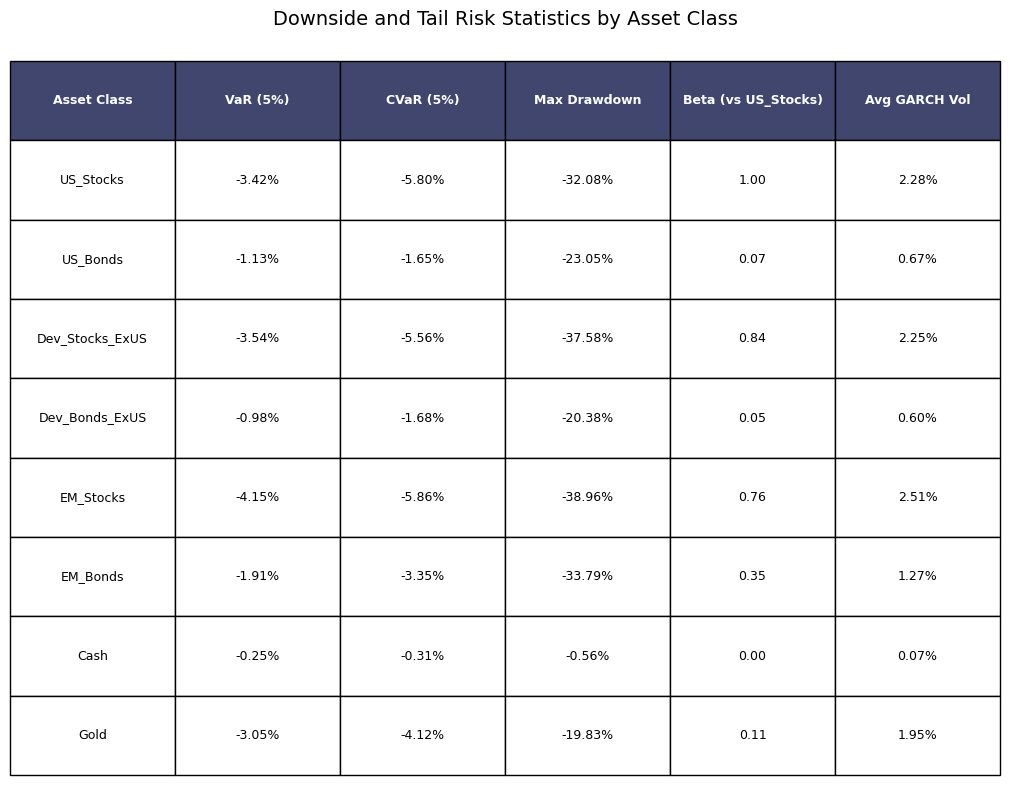

In [ ]:
# Downside and tail risk analysis for each asset class

# 1. Value at Risk (VaR) at 5% level
VaR_5 = simple_returns.quantile(0.05)

# 2. Conditional Value at Risk (CVaR) at 5% level
CVaR_5 = simple_returns[simple_returns.lt(VaR_5)].mean()

# 3. Maximum drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_dd = simple_returns.apply(max_drawdown)

# 4. Beta vs. US Stocks
us_stock_returns = simple_returns['US_Stocks']
betas = {}
for asset in assets:
    if asset == 'US_Stocks':
        betas[asset] = 1.0
    else:
        cov = simple_returns[asset].cov(us_stock_returns)
        var = us_stock_returns.var()
        betas[asset] = cov / var

betas = pd.Series(betas)

# Compile results
risk_stats = pd.DataFrame({
    'VaR (5%)': VaR_5,
    'CVaR (5%)': CVaR_5,
    'Max Drawdown': max_dd,
    'Beta (vs US_Stocks)': betas
})

try:
    garch_vols = {}
    for asset in assets:
        am = arch_model(simple_returns[asset]*100, vol='Garch', p=1, q=1, rescale=False)
        res = am.fit(disp='off')
        garch_vols[asset] = res.conditional_volatility.mean() / 100  # Convert back to original scale
    risk_stats['Avg GARCH Vol'] = pd.Series(garch_vols)
except ImportError:
    print("arch package not installed. Skipping GARCH volatility modeling.")

# === Format downside risk stats for display ===
risk_stats_fmt = risk_stats.copy().round(4).reset_index().rename(columns={'index': 'Asset Class'})

# Format columns as percentages
cols_pct = ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']
for col in cols_pct:
    risk_stats_fmt[col] = risk_stats_fmt[col].map(lambda x: f"{x:.2%}")

# Format Beta
risk_stats_fmt['Beta (vs US_Stocks)'] = risk_stats_fmt['Beta (vs US_Stocks)'].map(lambda x: f"{x:.2f}")

# === Create Matplotlib figure and axes ===
fig_risk = plt.figure(figsize=(11, 8.5))
ax = fig_risk.add_axes([0.05, 0.08, 0.9, 0.84])  # slightly inset to leave room for title
ax.axis('off')

# === Create the table ===
table = ax.table(
    cellText=risk_stats_fmt.values,
    colLabels=risk_stats_fmt.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.13] + [0.13] * (risk_stats_fmt.shape[1] - 1)
)

# === Format header row ===
for col_idx in range(len(risk_stats_fmt.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor("#40689c")          # dark blue
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_color("white")
    cell.get_text().set_fontsize(10)

# === General formatting ===
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

# === Add title ===
plt.suptitle("Downside and Tail Risk Statistics by Asset Class", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === Add to figures list for PDF export ===
figures.append(fig_risk)

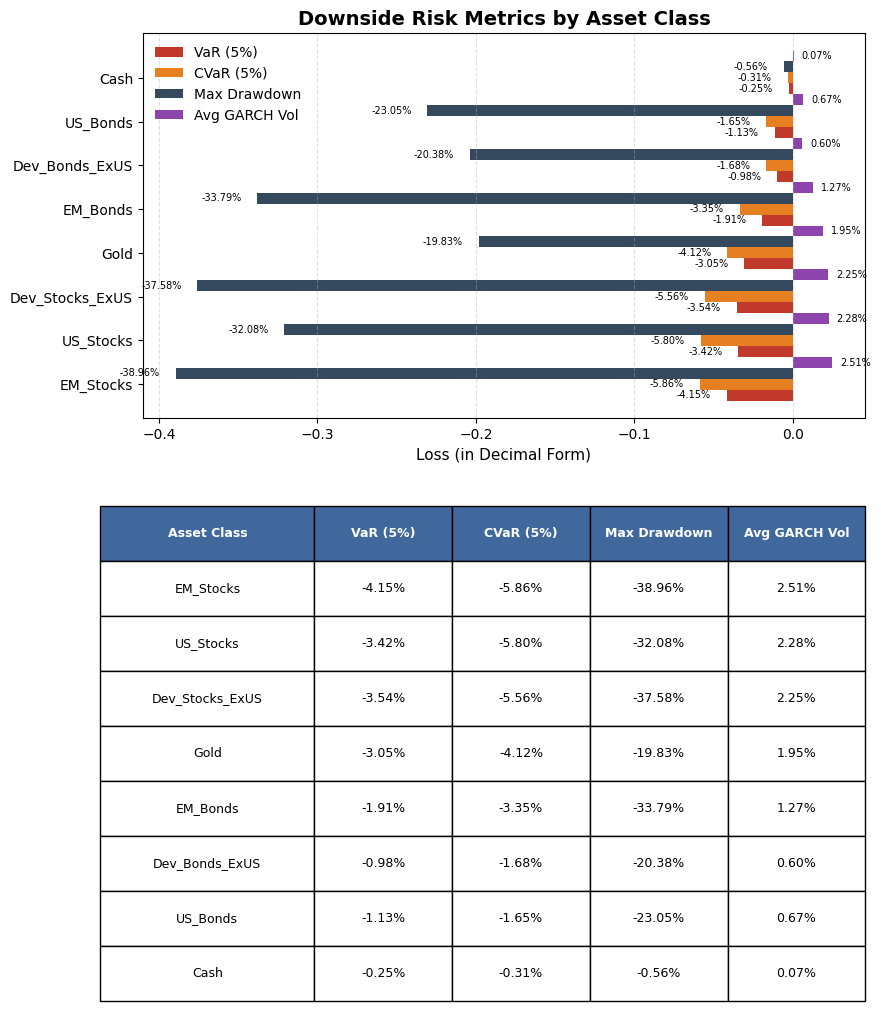

In [9]:
# Simulated already-formatted risk_stats (as the user has it)
risk_stats_plot = risk_stats[['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']].copy()
risk_stats_plot = risk_stats_plot.sort_values('CVaR (5%)')  # Sort to highlight exposure

# Convert figure size to portrait layout (8.5 x 11 inches)
fig_combined_portrait = plt.figure(figsize=(8.5, 11))

# === Top Plot Area ===
ax_chart = fig_combined_portrait.add_axes([0.1, 0.58, 0.85, 0.35])  # Adjusted for portrait layout

bar_width = 0.25
index = np.arange(len(risk_stats_plot))

bars_var = ax_chart.barh(index - bar_width, risk_stats_plot['VaR (5%)'], height=bar_width, label='VaR (5%)', color='#c0392b')
bars_cvar = ax_chart.barh(index, risk_stats_plot['CVaR (5%)'], height=bar_width, label='CVaR (5%)', color='#e67e22')
bars_dd = ax_chart.barh(index + bar_width, risk_stats_plot['Max Drawdown'], height=bar_width, label='Max Drawdown', color='#34495e')
bars_garch = ax_chart.barh(index + 2 * bar_width, risk_stats_plot['Avg GARCH Vol'], height=bar_width, label='Avg GARCH Vol', color='#8e44ad')   

# Add text labels
for bars in [bars_var, bars_cvar, bars_dd, bars_garch]:
    for bar in bars:
        width = bar.get_width()
        ax_chart.text(
            width - 0.01 if width < 0 else width + 0.005,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2%}",
            ha='right' if width < 0 else 'left',
            va='center',
            fontsize=7,
            color='black'
        )

ax_chart.set_yticks(index)
ax_chart.set_yticklabels(risk_stats_plot.index)
ax_chart.set_xlabel("Loss (in Decimal Form)", fontsize=11)
ax_chart.set_title("Downside Risk Metrics by Asset Class", fontsize=14)
ax_chart.legend()
ax_chart.grid(True, axis='x', linestyle='--', alpha=0.4)

# === Table Below Chart ===
ax_table = fig_combined_portrait.add_axes([0.05, 0.05, 0.9, 0.45])
ax_table.axis('off')

# Table formatting
risk_table_fmt = risk_stats_plot.copy().round(4).reset_index().rename(columns={"index": "Asset Class"})
for col in ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']:
    risk_table_fmt[col] = risk_table_fmt[col].map(lambda x: f"{x:.2%}")

table = ax_table.table(
    cellText=risk_table_fmt.values,
    colLabels=risk_table_fmt.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# Header formatting
for col_idx in range(len(risk_table_fmt.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor("#40689c")
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_color("white")
    cell.get_text().set_fontsize(10)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

figures.append(fig_combined_portrait)

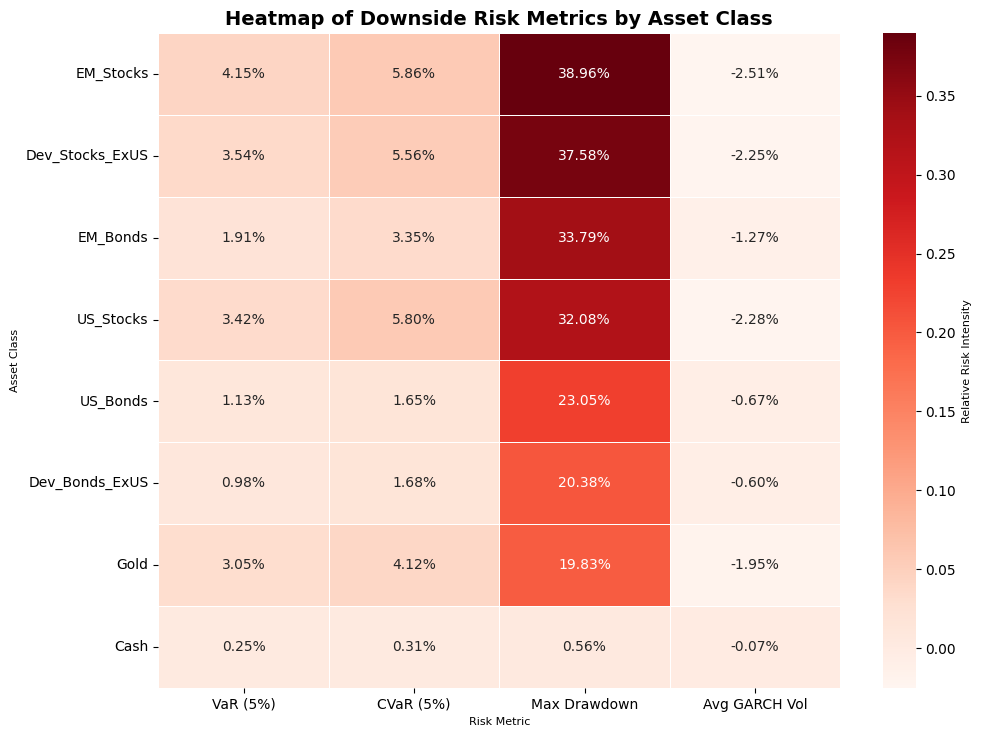

In [10]:
# Use downside risk metrics
available_metrics = ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']
risk_heatmap_data = risk_stats[available_metrics].copy()
risk_heatmap_data = risk_heatmap_data.sort_values('Max Drawdown')  # Sort by CVaR for better visualization

# Flip signs so higher values = higher risk (for heatmap visualization)
risk_heatmap_flipped = risk_heatmap_data.copy()
risk_heatmap_flipped[available_metrics] = -risk_heatmap_flipped[available_metrics]

# Create heatmap
fig_heatmap, ax = plt.subplots(figsize=(11, 8.5))

sns.heatmap(
    risk_heatmap_flipped,
    annot=True,
    fmt=".2%",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={"label": "Relative Risk Intensity"},
    ax=ax
)

ax.set_title("Heatmap of Downside Risk Metrics by Asset Class", fontsize=14)
ax.set_ylabel("Asset Class")
ax.set_xlabel("Risk Metric")

figures.append(fig_heatmap)

# 💹 Efficient Frontier & Portfolio Charts

# 🔗 Correlation Analysis

In [11]:
def plot_drawdown_curve(asset_name, returns_series, figures_list, threshold=-0.10):
    """
    Plot cumulative return and drawdown curve with drawdown periods highlighted.

    Parameters:
        asset_name (str): Name of the asset (e.g., 'US_Stocks')
        returns_series (pd.Series): Weekly or monthly returns for the asset
        figures_list (list): Your global list to append the figure for PDF export
    """
    # Compute cumulative return
    cumulative = (1 + returns_series).cumprod()

    # Compute drawdown
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak

    # Ensure float for plotting
    drawdown = drawdown.astype(float)

    # Create 2-row subplot layout
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(11, 8.5), sharex=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )

    # === Top Panel: Cumulative Returns ===
    ax1.plot(cumulative.index, cumulative, color='green', linewidth=1.5)
    ax1.set_title(f"Cumulative Return - {asset_name}", fontsize=14)
    ax1.set_ylabel("Cumulative Value")
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Highlight drawdown periods greater than 10%
    threshold = threshold # 10% drawdown
    drawdown_start = None

    for i in range(len(drawdown)):
        if drawdown.iloc[i] <= threshold and drawdown_start is None:
            drawdown_start = drawdown.index[i]
        elif drawdown.iloc[i] > threshold and drawdown_start is not None:
            ax1.axvspan(drawdown_start, drawdown.index[i], color='red', alpha=0.15)
            drawdown_start = None

    # Handle edge case: still in drawdown at end
    if drawdown_start is not None and drawdown.iloc[-1] <= threshold:
        ax1.axvspan(drawdown_start, drawdown.index[-1], color='red', alpha=0.15)


    # === Bottom Panel: Drawdown Curve ===
    ax2.fill_between(drawdown.index, drawdown.values, 0, color='salmon', alpha=0.8)
    ax2.set_title("Drawdown Curve", fontsize=12)
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Date")
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    figures_list.append(fig)  # Add to export list

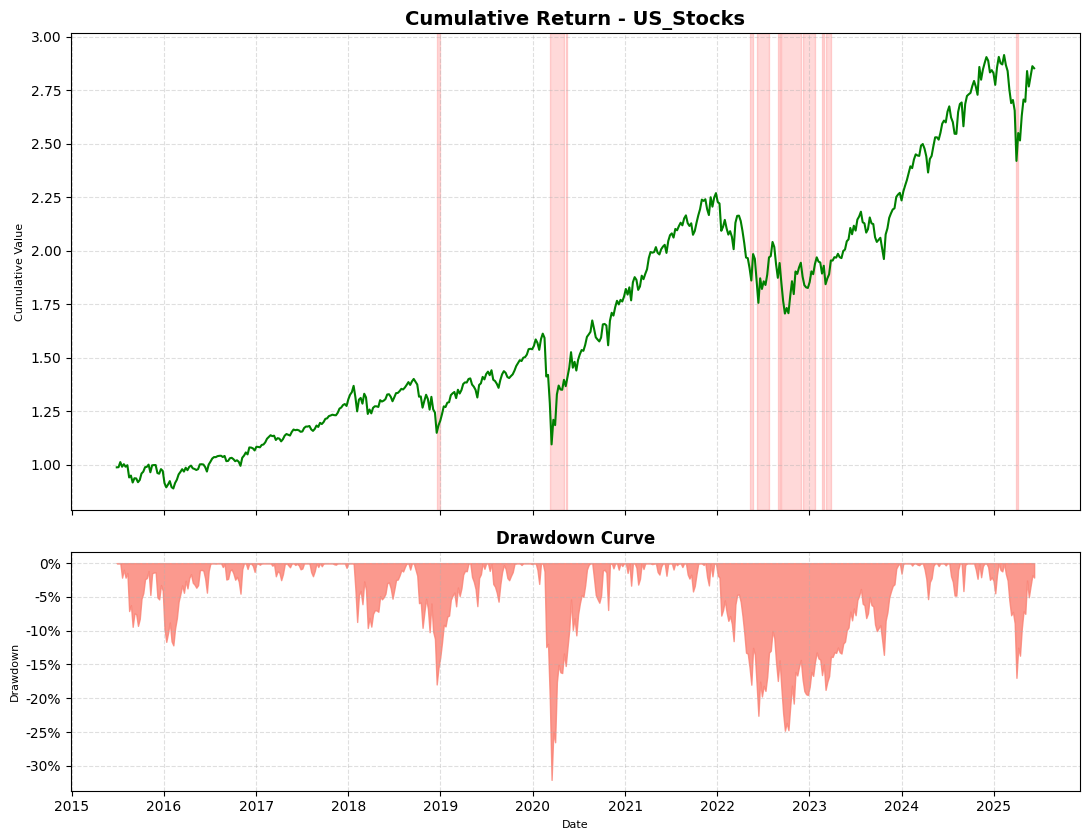

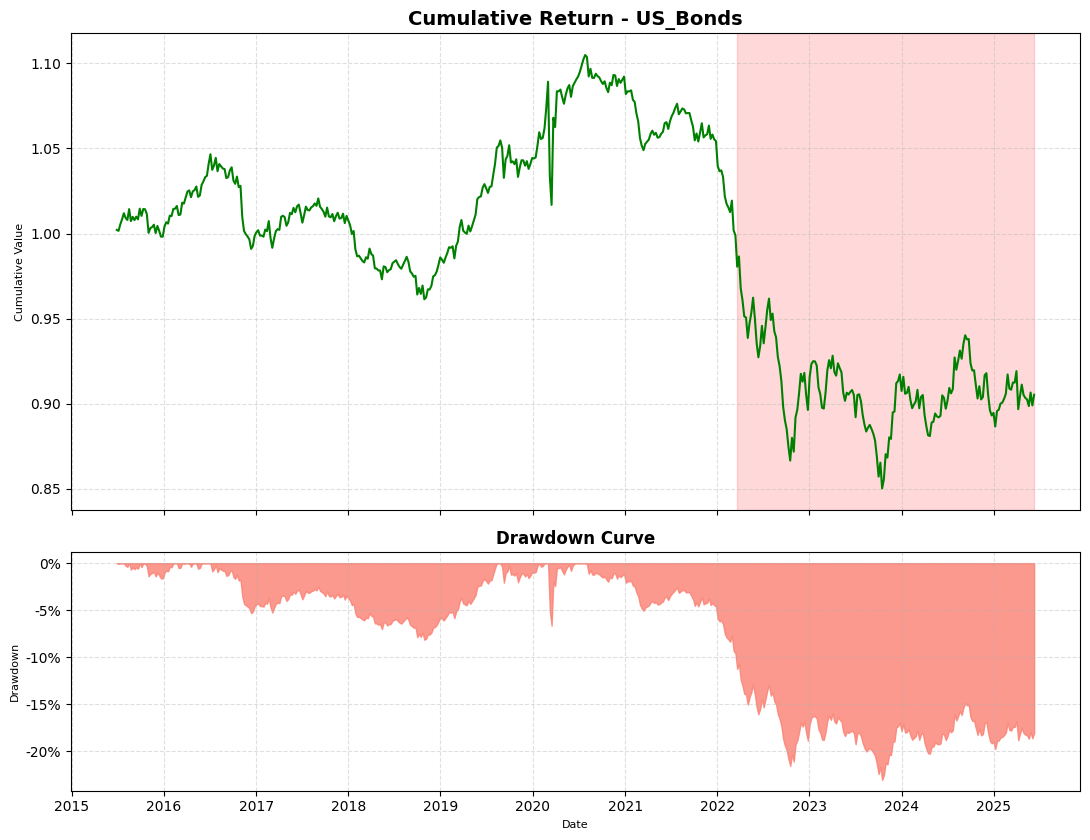

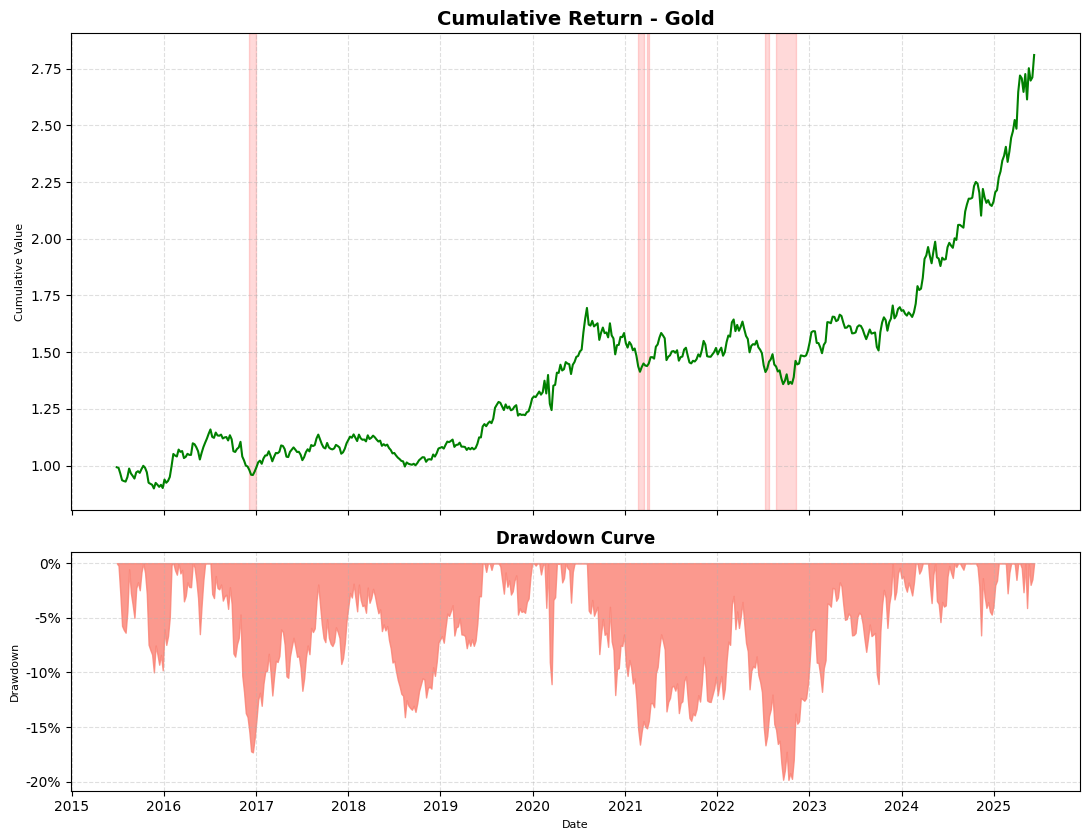

In [12]:
plot_drawdown_curve("US_Stocks", simple_returns['US_Stocks'], figures, threshold=-0.15)
plot_drawdown_curve("US_Bonds", simple_returns['US_Bonds'], figures, threshold=-0.10)
plot_drawdown_curve("Gold", simple_returns['Gold'], figures, threshold=-0.15)

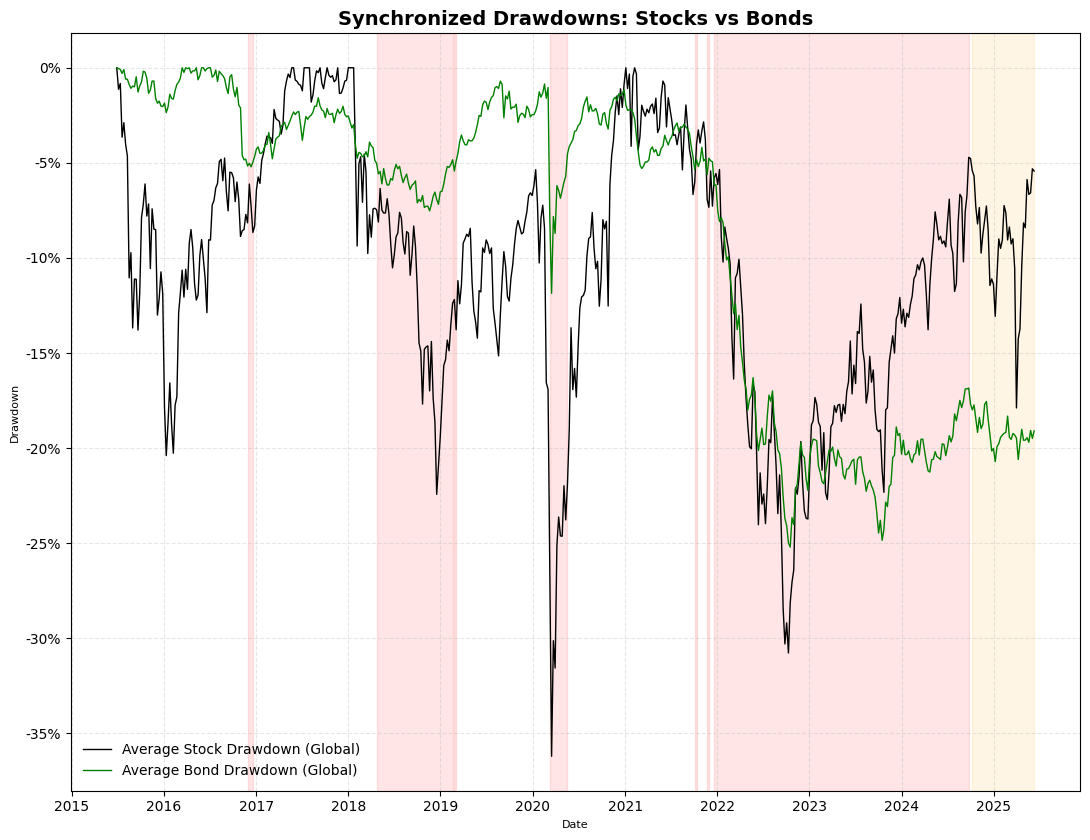

In [13]:
# Normalize asset prices (start all at 100)
normalized_prices = (1 + simple_returns).cumprod() * 100

# Compute drawdowns for each asset
drawdowns = pd.DataFrame(index=normalized_prices.index)
for col in normalized_prices.columns:
    peak = normalized_prices[col].cummax()
    drawdowns[col] = (normalized_prices[col] - peak) / peak

# Optional: group assets by type
stock_assets = ['US_Stocks', 'Dev_Stocks_ExUS', 'EM_Stocks']
bond_assets = ['US_Bonds', 'Dev_Bonds_ExUS', 'EM_Bonds']

# Calculate average stock and bond drawdowns
drawdowns['Stocks_Avg'] = drawdowns[stock_assets].mean(axis=1)
drawdowns['Bonds_Avg'] = drawdowns[bond_assets].mean(axis=1)

# === Plot synchronized drawdowns ===
fig_sync = plt.figure(figsize=(11, 8.5))
ax = fig_sync.add_subplot(111)

# Plot averaged stock and bond drawdowns
ax.plot(drawdowns.index, drawdowns['Stocks_Avg'], label='Average Stock Drawdown (Global)', color='black', linewidth=1)
ax.plot(drawdowns.index, drawdowns['Bonds_Avg'], label='Average Bond Drawdown (Global)', color='green', linewidth=1)

# Highlight synchronized drawdowns (both < -5% at same time)
sync = (drawdowns['Stocks_Avg'] < -0.05) & (drawdowns['Bonds_Avg'] < -0.05)
sync_regions = sync.astype(int).diff().fillna(0)

# Add shading
for i in range(1, len(sync_regions)):
    if sync_regions.iloc[i] == 1:
        start = drawdowns.index[i]
    elif sync_regions.iloc[i] == -1:
        end = drawdowns.index[i]
        ax.axvspan(start, end, color='red', alpha=0.1)

# If still in sync at end of series
if sync.iloc[-1]:
    ax.axvspan(start, drawdowns.index[-1], color='orange', alpha=0.1)

# Style the chart
# This chart shows synchronized drawdowns for stocks and bonds.
# "Stocks" and "Bonds" are each an average of US (domestic), developed ex-US, and emerging markets.
# Thus, the drawdown curves represent a global blend of all major market regions.
ax.set_title("Synchronized Drawdowns: Stocks vs Bonds", fontsize=14) 
ax.set_ylabel("Drawdown")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

fig_sync.tight_layout()
figures.append(fig_sync)

# 📉 Risk Metrics: VaR, CVaR, Drawdown

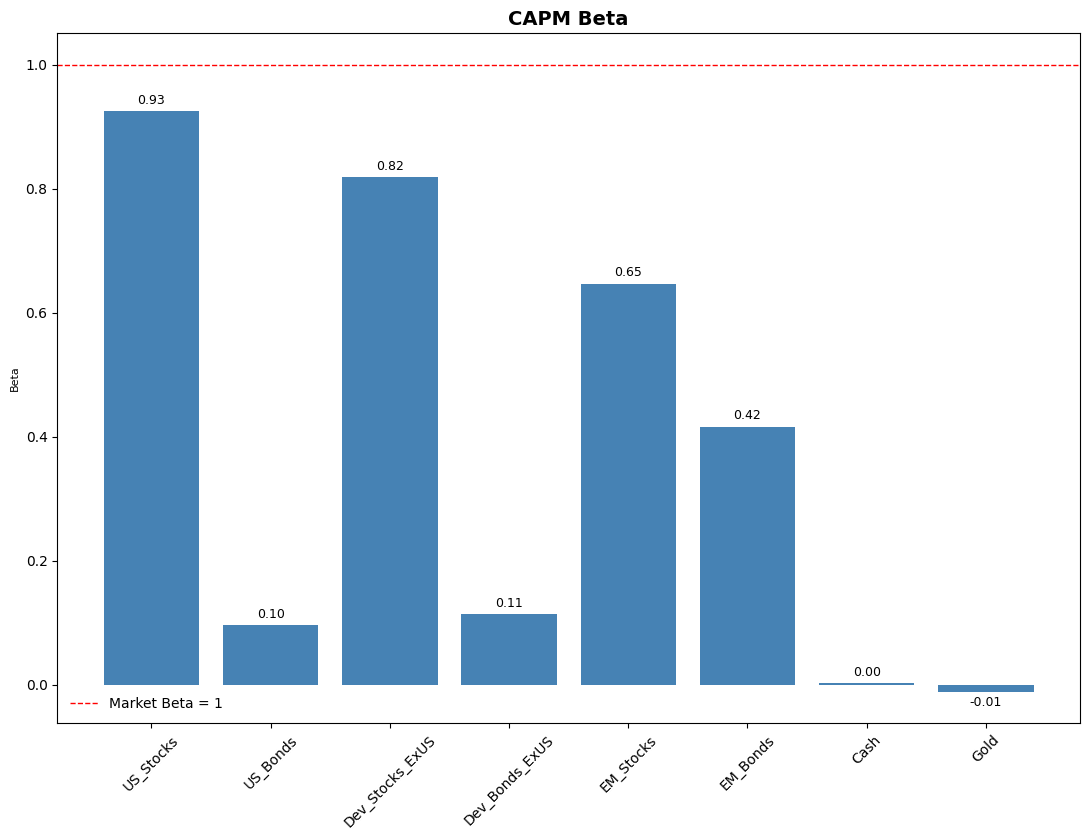

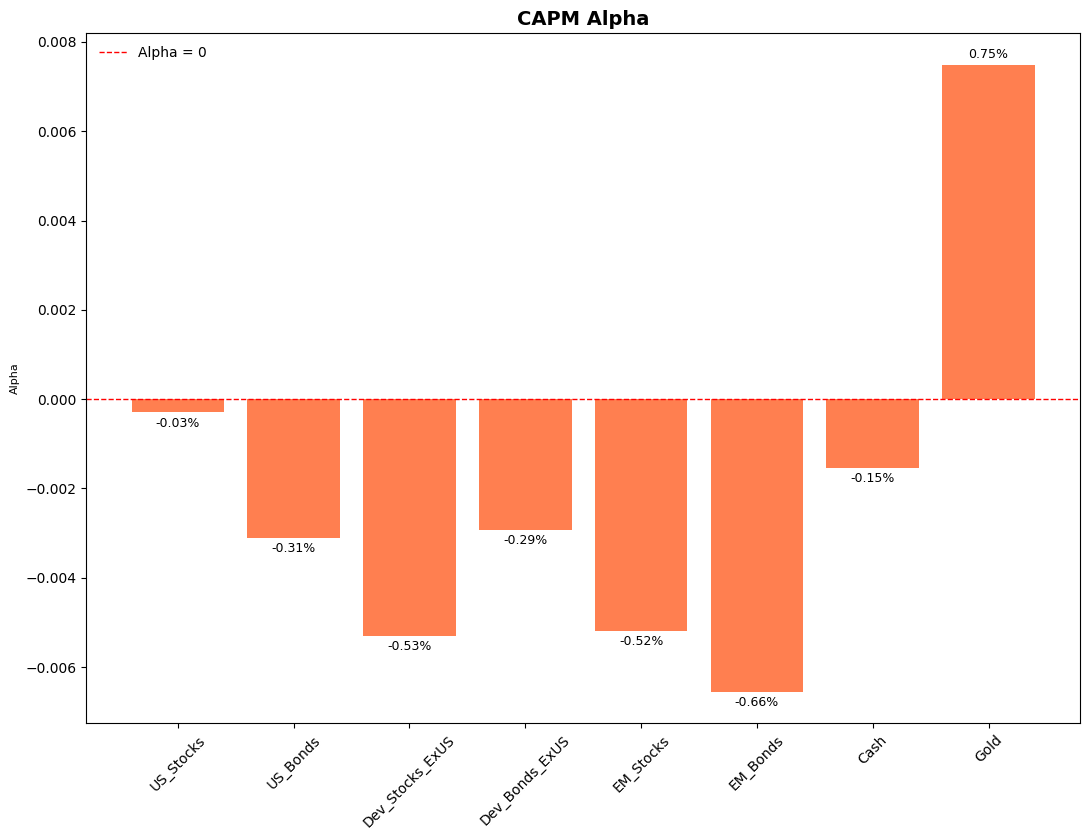

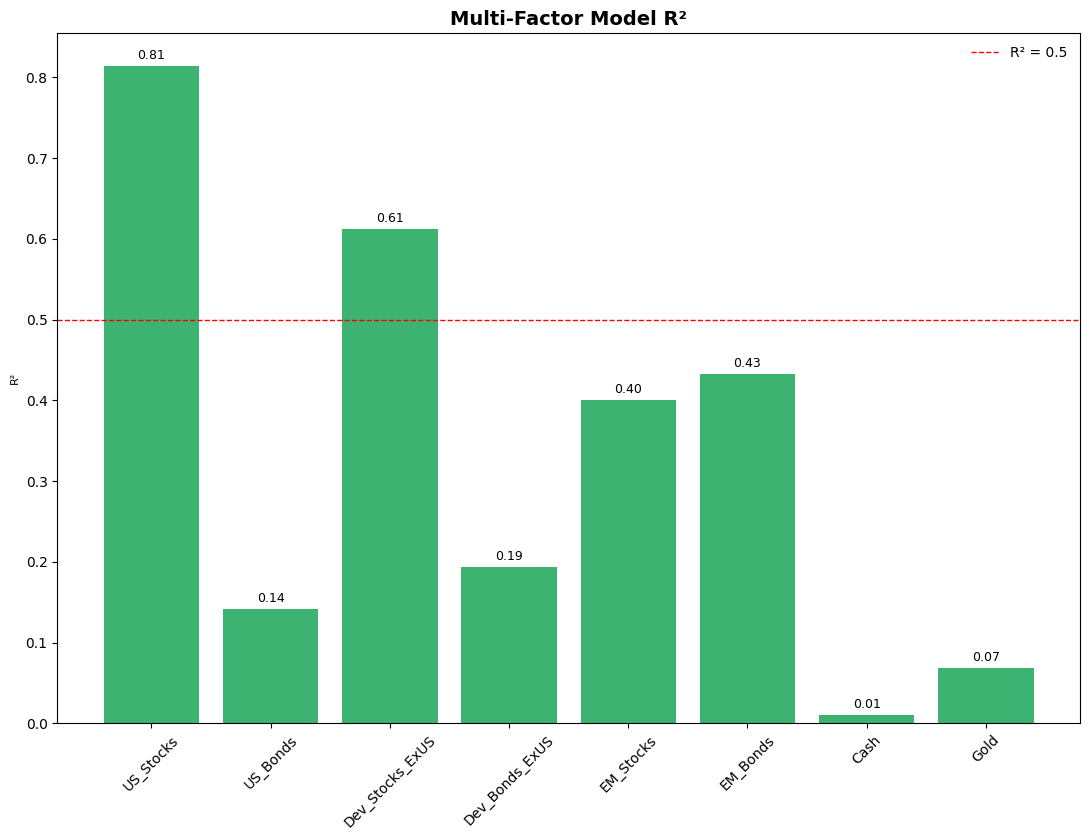

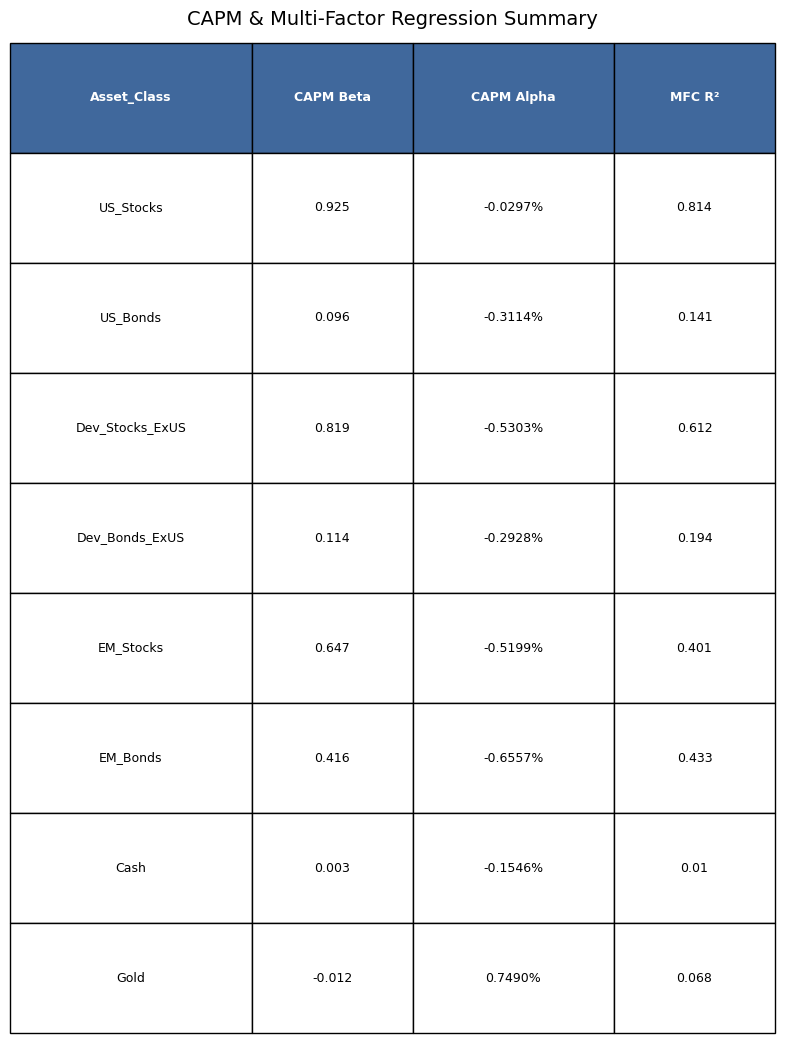

In [14]:
# Calculate monthly returns from weekly data
monthly_returns = simple_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M') - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Download Fama-French factors and momentum data
# Load local CSVs from Kenneth French (already downloaded and cleaned)
ff_factors = pd.read_csv('data/F-F_Research_Data_Factor.csv', skiprows=3)
momentum = pd.read_csv('data/F-F_Momentum_Factor.csv', skiprows=13)

# Clean and parse dates
ff_factors = ff_factors.rename(columns={ff_factors.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
ff_factors = ff_factors[ff_factors['Date'].astype(str).str.match(r'^\d{6}$')]
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
# Set datetime as index and convert values to decimal
ff_factors.set_index('Date', inplace=True)
ff_factors = ff_factors.astype(float) / 100

# Optional: Rename for compatibility
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

momentum = momentum.rename(columns={momentum.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
momentum = momentum[momentum['Date'].astype(str).str.match(r'^\d{6}$')]
momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m')
momentum.set_index('Date', inplace=True)
momentum = momentum.astype(float) / 100
momentum = momentum.rename(columns={momentum.columns[0]: 'Mom'})

# Merge with Fama-French data
ff_factors = ff_factors.join(momentum)
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

# Align dates with your monthly returns
common_end = min(monthly_returns.index.max(), ff_factors.index.max())
ff_factors_aligned = ff_factors.loc[monthly_returns.index.min():common_end]
monthly_returns_aligned = monthly_returns.loc[monthly_returns.index.min():common_end]

# Perform CAPM and Multi-Factor Model regressions
regression_results = {}
capm_betas, capm_alphas, mfc_r2 = [], [], []

for asset in monthly_returns.columns:
    df = pd.concat([monthly_returns[asset], ff_factors_aligned], axis=1).dropna()
    df.columns = ['Ret', 'Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

    if df.empty:
        print(f"⚠️ Skipping {asset}: no overlapping data.")
        continue

    y = df['Ret'] - df['RF']

    X_capm = sm.add_constant(df['Mkt_RF'])
    capm_model = sm.OLS(y, X_capm).fit()

    X_mfc = sm.add_constant(df[['Mkt_RF', 'SMB', 'HML']])
    mfc_model = sm.OLS(y, X_mfc).fit()

    regression_results[asset] = {'CAPM': capm_model, 'MFC': mfc_model}
    capm_betas.append(capm_model.params['Mkt_RF'])
    capm_alphas.append(capm_model.params['const'])
    mfc_r2.append(mfc_model.rsquared)

regression_assets = monthly_returns.columns.tolist()

# === Plot 1: CAPM Beta ===
fig_capm, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, capm_betas, color='steelblue')
ax.set_title('CAPM Beta', fontsize=14)
ax.set_ylabel('Beta')
ax.axhline(1, color='red', linestyle='--', linewidth=1, label='Market Beta = 1')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{b:.2f}" for b in capm_betas], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_capm)

# === Plot 2: CAPM Alpha ===
fig_alpha, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, capm_alphas, color='coral')
ax.set_title('CAPM Alpha', fontsize=14)
ax.set_ylabel('Alpha')
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Alpha = 0')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{a:.2%}" for a in capm_alphas], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_alpha)

# === Plot 3: Multi-Factor R² ===
fig_multi, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, mfc_r2, color='mediumseagreen')
ax.set_title('Multi-Factor Model R²', fontsize=14)
ax.set_ylabel('R²')
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, label='R² = 0.5')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{r2:.2f}" for r2 in mfc_r2], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_multi)

# Generate summary text for CAPM and Multi-Factor Model results
rows = []

for asset in regression_assets:
    capm = regression_results[asset]['CAPM']
    mfc = regression_results[asset]['MFC']

    rows.append({
        "Asset_Class": asset,
        "CAPM Beta": round(capm.params['Mkt_RF'], 3),
        "CAPM Alpha": f"{capm.params['const']:.4%}",
        "MFC R²": round(mfc.rsquared, 3)
    })

# Convert to DataFrame
regression_df = pd.DataFrame(rows)

fig_regg = plt.figure(figsize=(8.5, 11))
ax = fig_regg.add_axes([0.05, 0.05, 0.9, 0.9]) 
ax.axis('off')

table = ax.table(
    cellText=regression_df.values,
    colLabels=regression_df.columns,
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.3, 0.2, 0.25, 0.2]
)

header_props = {
    "facecolor": "#40689c",
    "edgecolor": "white",
    "text_props": {
        "weight": "bold",
        "color": "white",
        "fontsize": 10
    }
}

# Apply formatting to each header cell
for col_idx in range(len(regression_df.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor(header_props["facecolor"])
    cell.get_text().set_fontweight(header_props["text_props"]["weight"])
    cell.get_text().set_color(header_props["text_props"]["color"])
    cell.get_text().set_fontsize(header_props["text_props"]["fontsize"])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.suptitle("CAPM & Multi-Factor Regression Summary", fontsize=14, y=0.98)
plt.show()
figures.append(fig_regg)


In [15]:
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 52
cov_matrix = returns.cov() * 52

# Portfolio simulation with constraints
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    while True:
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        # Enforce min/max constraints
        valid = True
        for j, asset in enumerate(assets):
            if asset in constraints:
                rule = constraints[asset]
                if 'max' in rule and weights[j] > rule['max']:
                    valid = False
                    break
                if 'min' in rule and weights[j] < rule['min']:
                    valid = False
                    break
        if valid:
            break

    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe
    weights_record.append(weights)

# Find portfolio with max Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_portfolio = pd.Series(optimal_weights, index=assets)
opt_port = optimal_portfolio.reset_index()
opt_port.columns = ['Asset_Class', 'Weight']


# Calculate optimal portfolio metrics
optimal_volatility = results[1, max_sharpe_idx]
optimal_return = results[0, max_sharpe_idx]
max_sharpe = results[2, max_sharpe_idx]

with redirect_stdout(stdout_buffer):
    # Print optimal allocation
    print("Optimal Portfolio Allocation (with Constraints):")
    print(opt_port.round(4))
    print(f"Expected Annual Return: {optimal_return:.4f}")
    print(f"Expected Annual Volatility: {optimal_volatility:.4f}")  
    print(f"Max Sharpe Ratio: {max_sharpe:.4f}")

    for asset, weight in zip(assets, optimal_weights):
        if asset in constraints:
            rule = constraints[asset]
            if 'min' in rule and weight < rule['min']:
                print(f"❌ {asset} violates MIN: {weight:.4f} < {rule['min']}")
            if 'max' in rule and weight > rule['max']:
                print(f"❌ {asset} violates MAX: {weight:.4f} > {rule['max']}")

# Save optimal portfolio to CSV

opt_port.to_csv("exports/optimal_portfolio_with_constraints.csv")
print("Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.")

Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.


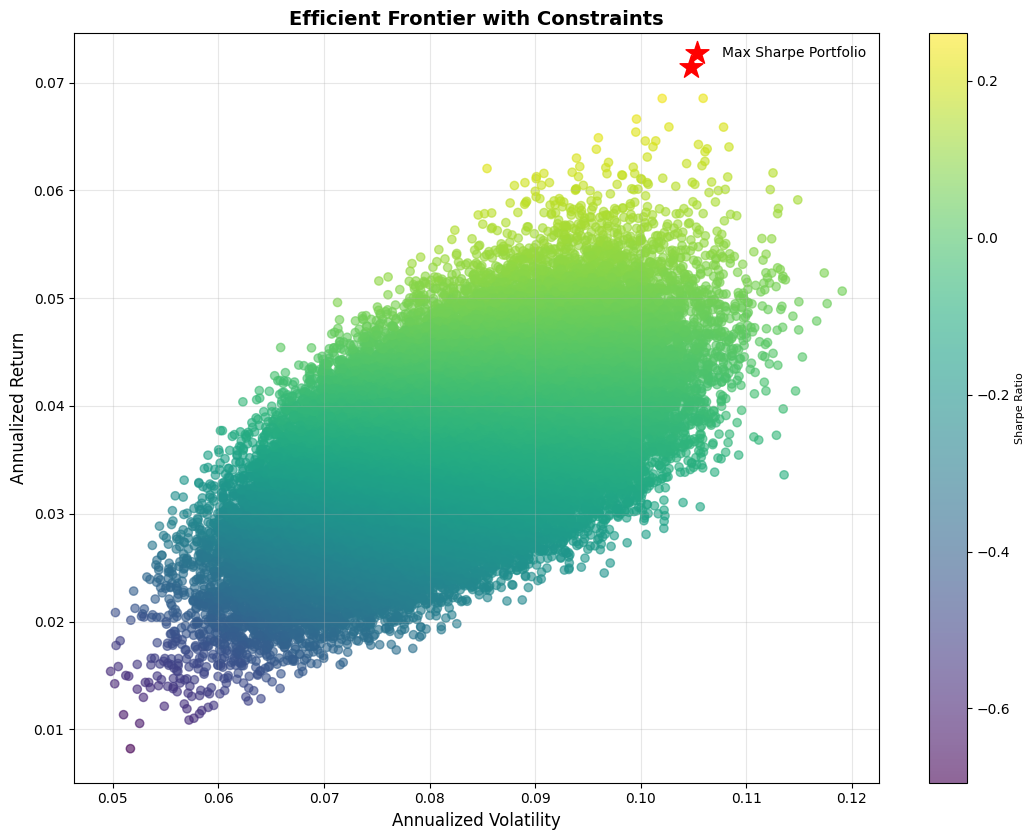

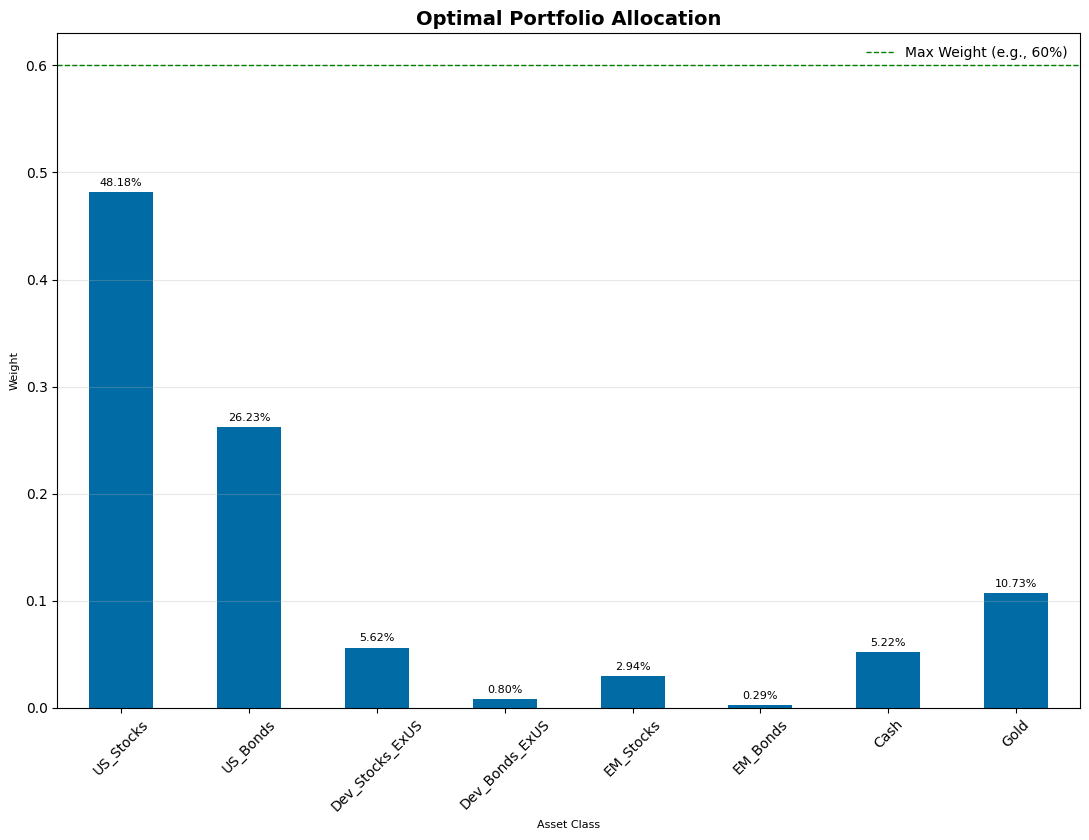

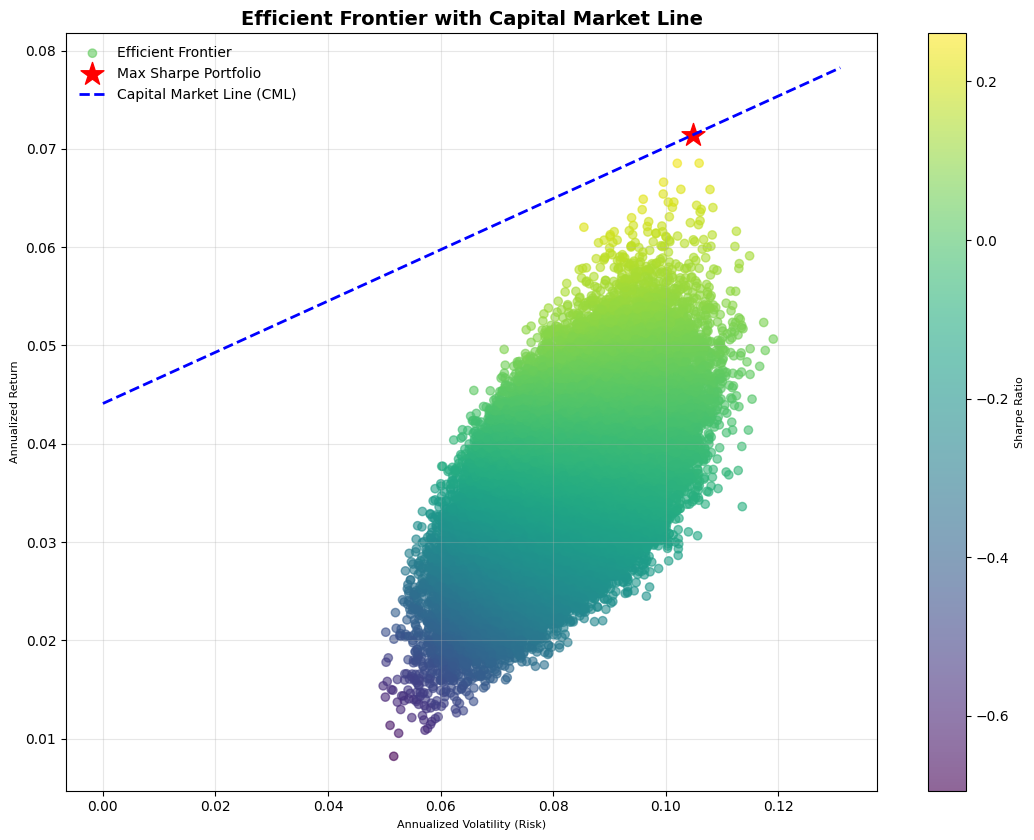

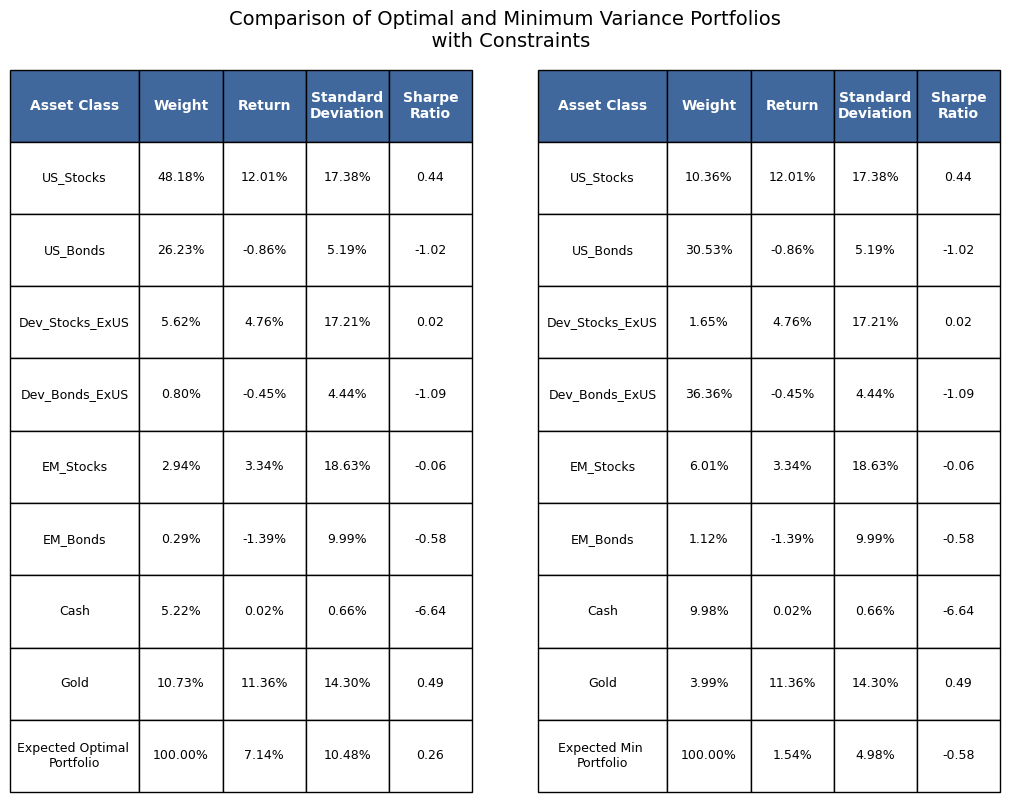

In [16]:
# Plot efficient frontier
fig1 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.title("Efficient Frontier with Constraints", fontsize=14)
plt.xlabel("Annualized Volatility", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig1)


fig2, ax = plt.subplots(figsize=(11, 8.5))

# Plot and get BarContainer
bars = optimal_portfolio.plot(kind='bar', ax=ax)

ax.set_title("Optimal Portfolio Allocation", fontsize=14)
ax.set_ylabel("Weight")
ax.set_xlabel("Asset Class")
ax.grid(axis='y')
ax.axhline(y=0.6, color='green', linestyle='--', linewidth=1, label='Max Weight (e.g., 60%)')

# Add bar labels (percentage)
ax.bar_label(ax.containers[0], labels=[f"{w:.2%}" for w in optimal_portfolio], label_type='edge', fontsize=8, padding=3)

ax.set_xticklabels(optimal_portfolio.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

figures.append(fig2)

# Define x-axis range: from 0 to a bit beyond the optimal volatility
x = np.linspace(0, max(results[1]) * 1.1, 100)

# CML equation: R = Rf + Sharpe * σ
cml = risk_free_rate + max_sharpe * x

# Plot Efficient Frontier
fig3 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6, label='Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.plot(x, cml, color='blue', linestyle='--', linewidth=2, label='Capital Market Line (CML)')
plt.title("Efficient Frontier with Capital Market Line")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig3)

annual_returns = mean_returns
annual_vols = simple_returns.std() * np.sqrt(52)
sharpe_series = (annual_returns - risk_free_rate) / annual_vols

table_df = pd.DataFrame({
    "Weight": optimal_portfolio.round(4).apply(lambda x: f"{x:.2%}"),
    "Return": annual_returns.round(4).apply(lambda x: f"{x:.2%}"),
    "Std Dev": annual_vols.round(4).apply(lambda x: f"{x:.2%}"),
    "Sharpe Ratio": sharpe_series.round(4).apply(lambda x: f"{x:.2f}")
}).loc[optimal_portfolio.index]

table_df = table_df.reset_index().rename(columns={"Ticker": "Asset_Class"})

summary_row = pd.DataFrame({
    "Asset_Class": ["Expected Optimal \nPortfolio"],
    "Weight": [f"{optimal_portfolio.sum():.2%}"],
    "Return": [f"{optimal_return:.2%}"],
    "Std Dev": [f"{optimal_volatility:.2%}"],
    "Sharpe Ratio": [f"{max_sharpe:.2f}"]
})

table_df = pd.concat([table_df, summary_row], ignore_index=True)

# Calculate minimum variance portfolio
sharpe_ratios = results[2]
portfolio_returns = results[0]
portfolio_vols = results[1]
min_var_idx = np.argmin(portfolio_vols)
min_var_weights = weights_record[min_var_idx]

min_var_return = portfolio_returns[min_var_idx]
min_var_volatility = portfolio_vols[min_var_idx]
min_var_ratio = sharpe_ratios[min_var_idx]

# === Create table for min variance portfolio ===
minvar_table_df = pd.DataFrame({
    "Weight": pd.Series(min_var_weights, index=assets).round(4).apply(lambda x: f"{x:.2%}"),
    "Return": annual_returns.round(4).apply(lambda x: f"{x:.2%}"),
    "Std Dev": annual_vols.round(4).apply(lambda x: f"{x:.2%}"),
    "Sharpe Ratio": sharpe_series.round(4).apply(lambda x: f"{x:.2f}")
}).loc[assets]

minvar_table_df = minvar_table_df.reset_index().rename(columns={"Ticker": "Asset_Class"})

minvar_summary_row = pd.DataFrame({
    "Asset_Class": ["Expected Min \nPortfolio"],
    "Weight": [f"{sum(min_var_weights):.2%}"],
    "Return": [f"{min_var_return:.2%}"],
    "Std Dev": [f"{min_var_volatility:.2%}"],
    "Sharpe Ratio": [f"{min_var_ratio:.2f}"]
})

minvar_table_df = pd.concat([minvar_table_df, minvar_summary_row], ignore_index=True)


# === Create figure with 2 side-by-side tables ===
fig_compare = plt.figure(figsize=(11, 8.5))
ax1 = fig_compare.add_axes([0.05, 0.05, 0.42, 0.85])
ax2 = fig_compare.add_axes([0.53, 0.05, 0.42, 0.85])

ax1.axis('off')
ax2.axis('off')

# Optimal Portfolio Table
table1 = ax1.table(
    cellText=table_df.values,
    colLabels=['Asset Class', 'Weight', 'Return', 'Standard\nDeviation', 'Sharpe\nRatio'],
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# Minimum Variance Table
table2 = ax2.table(
    cellText=minvar_table_df.values,
    colLabels=['Asset Class', 'Weight', 'Return', 'Standard\nDeviation', 'Sharpe\nRatio'],
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# === Style both table headers ===
for t in [table1, table2]:
    t.auto_set_font_size(False)
    t.set_fontsize(9)
    t.scale(1.2, 1.2)
    for col_idx in range(len(table_df.columns)):
        cell = t[(0, col_idx)]
        cell.set_facecolor("#40689c")
        cell.get_text().set_fontweight("bold")
        cell.get_text().set_color("white")
        cell.get_text().set_fontsize(10)

# === Add shared title ===
fig_compare.suptitle("Comparison of Optimal and Minimum Variance Portfolios\n  with Constraints", fontsize=14, y=0.97)

# === Save to export list ===
figures.append(fig_compare)

In [17]:
def plot_optimal_weights(ax, portfolio_series=None):
    if portfolio_series is None:
        portfolio_series = optimal_portfolio

    weights = portfolio_series.sort_values(ascending=False)
    bars = ax.bar(weights.index, weights.values, color='steelblue', align='center')

    ax.set_ylabel("Weight")
    ax.set_ylim(0, max(weights.max() * 1.2, 0.15))

    ax.set_xticks(range(len(weights)))
    ax.set_xticklabels(weights.index, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2%}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4), textcoords="offset points", ha='center', fontsize=9)

    ax.grid(axis='y', linestyle='--', alpha=0.3)

# Table: same data as chart (but can differ if needed)
summary_row = pd.DataFrame({
    "Asset_Class": ["Expected Portfolio Return & Std Dev"],
    "Weight": [f"{optimal_portfolio.sum():.2%}"],
    "Return": [f"{optimal_return:.2%}"],
    "Std Dev": [f"{optimal_volatility:.2%}"]
})

table_df = pd.DataFrame({
    "Weight": optimal_portfolio.round(4).apply(lambda x: f"{x:.2%}"),
    "Return": mean_returns.round(4).apply(lambda x: f"{x:.2%}"),
    "Std Dev": (simple_returns.std() * np.sqrt(52)).round(4).apply(lambda x: f"{x:.2%}")
}).loc[optimal_portfolio.index]
table_df = table_df.reset_index()
table_df = table_df.rename(columns={"Ticker": "Asset_Class"})
table_df = pd.concat([table_df, summary_row], ignore_index=True)

export_chart_with_table(plot_optimal_weights, table_df)

PDF saved to: exports\optimization_weights_summary.pdf


In [18]:
captured_output = stdout_buffer.getvalue()

fig_prints = plt.figure(figsize=(8.5, 11))
plt.axis('off')
plt.text(0, 1, captured_output, fontsize=7, fontfamily='arial', verticalalignment='top', 
         wrap=True)
figures.append(fig_prints)

generate_pdf_report(figures)

'exports\\portfolio_summary_report.pdf'

# ⚙️ Portfolio Optimization Simulation

# 🧮 Regression Analysis (CAPM / Multi-Factor)